In [1]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pystac
from pystac.extensions.eo import EOExtension as eo
import pystac_client
from pystac_client import Client
import planetary_computer
import requests
import rich.table

import odc.stac
from datacube.utils.cog import write_cog

from scipy.ndimage import uniform_filter
from scipy.ndimage import variance
from scipy.ndimage import generic_filter
from scipy.stats import mode

from IPython.display import Image

from osgeo import gdal
import os
import glob

import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import colormaps

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE









In [3]:
#NBR_PRE

In [4]:
# Define the area of interest with CRS information
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [149.473, -35.000],
            [150.621, -35.000],
            [150.621, -35.786],
            [149.473, -35.786],
            [149.473, -35.000]
        ]
    ],
    "crs": "EPSG:32756"  # Specify the CRS (WGS84 in this case)
}

# Define the time of interest
time_of_interest_pre = "2019-12-01T00:00:00Z/2019-12-10T23:59:59Z"

# Open the STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search for items within the defined area and time range
search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest_pre,
    query={"eo:cloud_cover": {"lt": 90}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")


/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Returned 2 Items


In [5]:
selected_item_pre = items[0]

print(
    f"Choosing {selected_item_pre.id} from {selected_item_pre.datetime.date()}"
    
)

Choosing LC08_L2SP_089085_20191208_02_T1 from 2019-12-08


In [6]:
selected_item_pre

<Item id=LC08_L2SP_089085_20191208_02_T1>

In [7]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [8]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item_pre, "red").href,
    find_asset_by_band_common_name(selected_item_pre, "green").href,
    find_asset_by_band_common_name(selected_item_pre, "blue").href,
    
]

signed_hrefs = [planetary_computer.sign(asset_href) for asset_href in asset_hrefs]

In [9]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image


def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)


bands = [read_band(href) for href in signed_hrefs]

In [10]:
multiband_data = np.stack(bands)

In [ ]:
#%%time

#rescaled = multiband_data.astype(float)
#min_value, max_value = rescaled.min(), rescaled.max()
#rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
#byte_data = rescaled.astype("ubyte")
#Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

In [12]:
# render an indicie image (NDVI WITH CLOUD BELOW)
r = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_pre, "red").href),
    
).astype(float)

nir = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_pre, "nir08").href),
    
).astype(float)

ndvi = (nir - r) / (nir + r)
w = ndvi.shape[0]
h = ndvi.shape[1]

/tmp/ipykernel_1064/2142488951.py:12: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - r) / (nir + r)


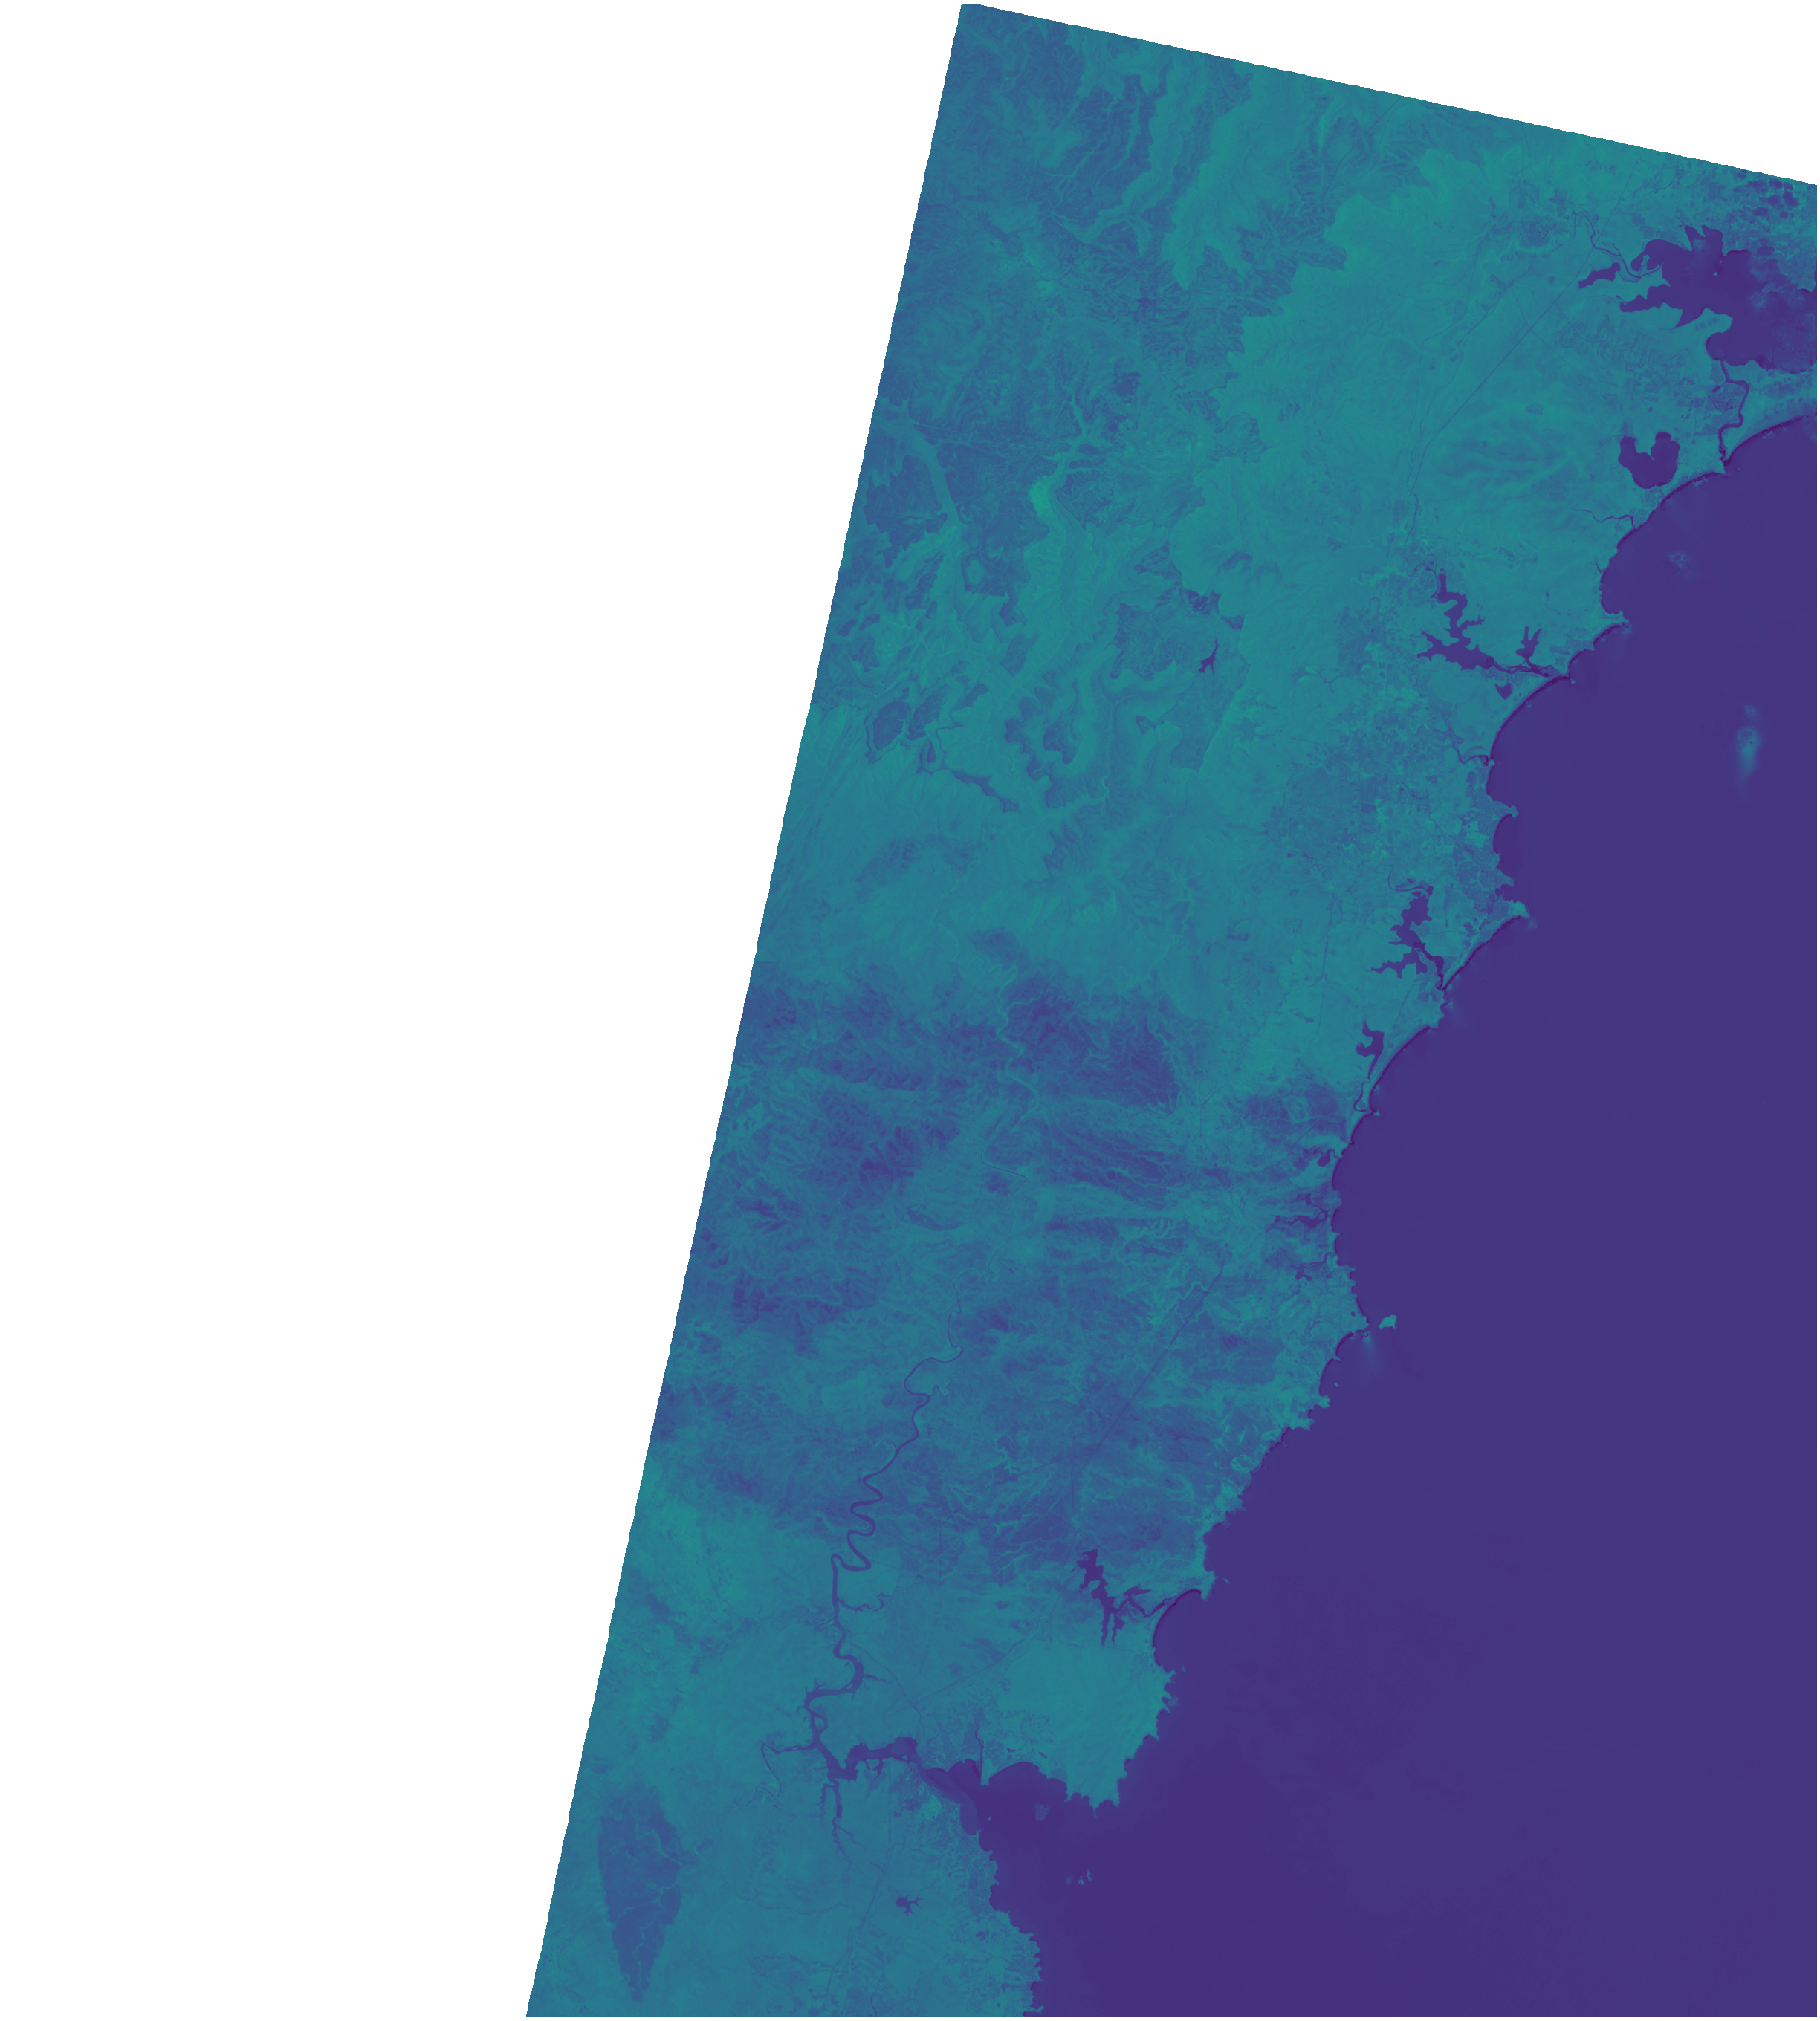

In [13]:


dpi = 50
fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis");

In [14]:
# render an indicie image (dNB WITH CLOUD BELOW)
swir22 = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_pre, "swir22").href),
   
).astype(float)

nir = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_pre, "nir08").href),
   
).astype(float)

nbr_pre = (nir - swir22) / (nir + swir22)
w = nbr_pre.shape[0]
h = nbr_pre.shape[1]

/tmp/ipykernel_1064/2303313202.py:12: RuntimeWarning: invalid value encountered in divide
  nbr_pre = (nir - swir22) / (nir + swir22)


In [15]:
nbr_pre.shape


(3011, 2710)

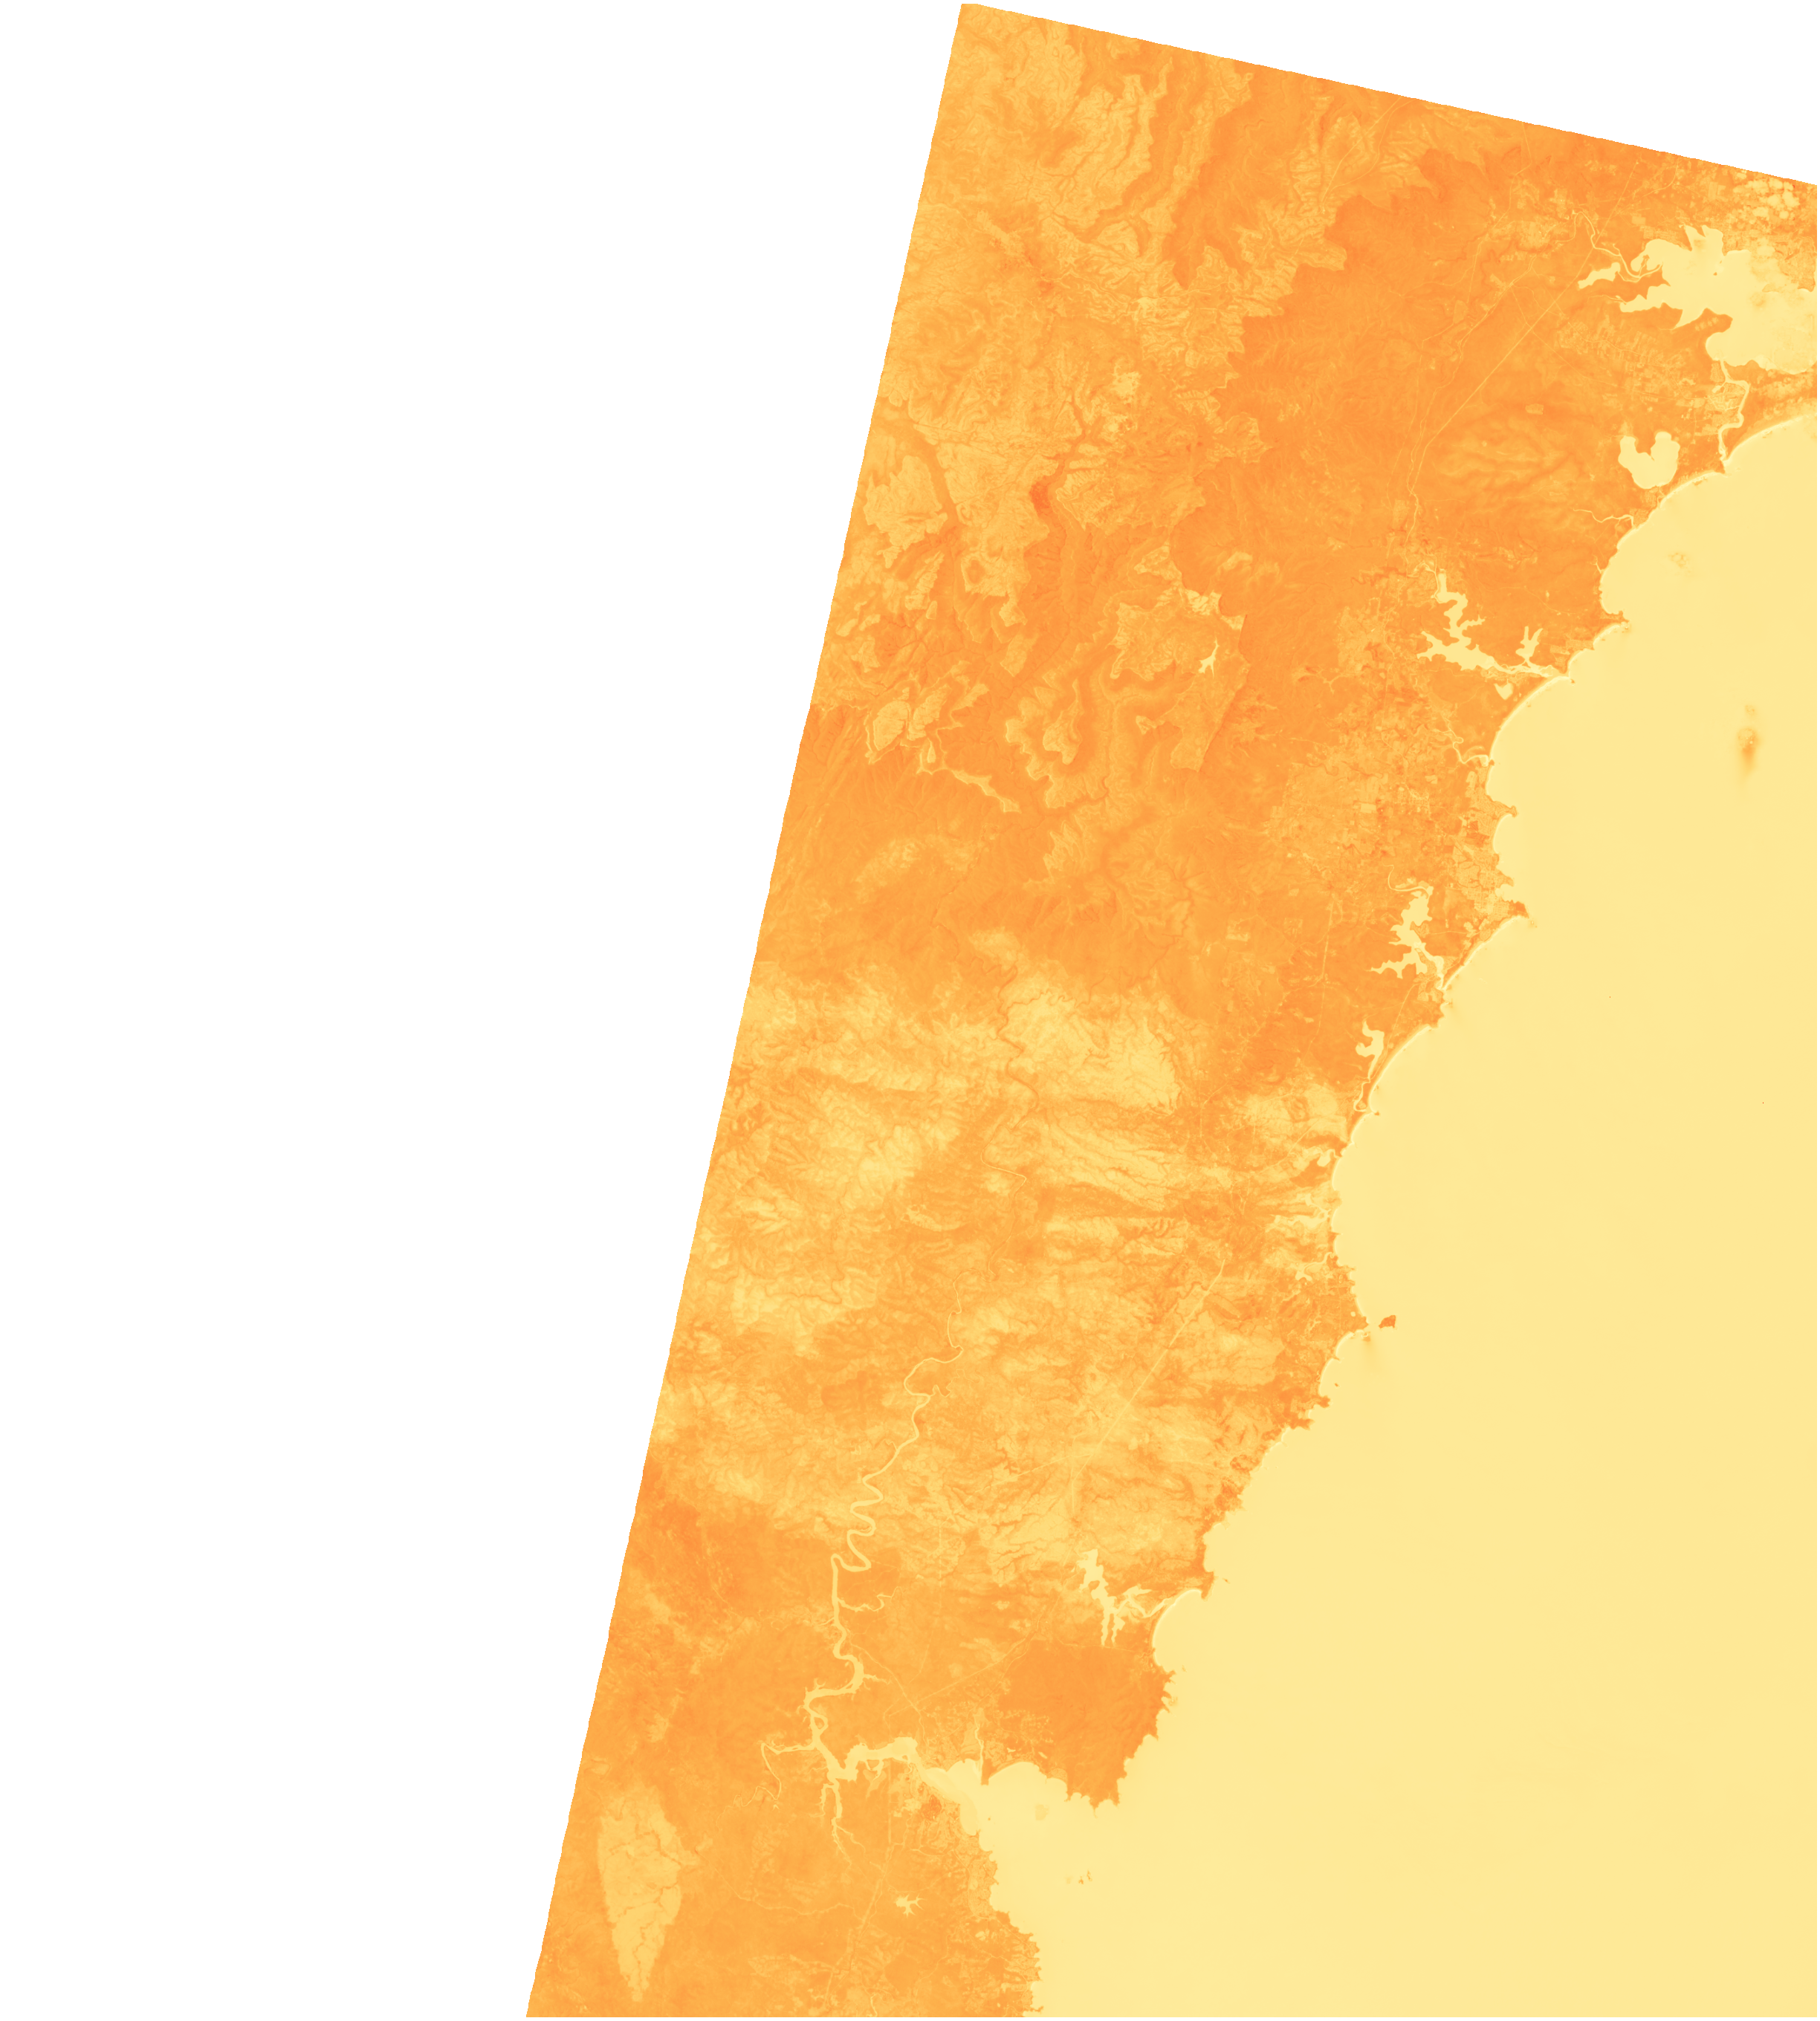

In [16]:
dpi = 50
fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="YlOrRd");

In [ ]:
nbr_pre.shape

In [ ]:

from rasterio.transform import from_origin

# Define the dimensions of the array (height, width)
height, width = nbr_pre.shape

# Define the spatial extent of the array (left, bottom, right, top)
# This defines the bounding box of the array in the coordinate reference system
left = 149.473  # min longitude
bottom = -35.786  # min latitude
right = 150.621  # max longitude
top = -35.000  # max latitude


# Define the resolution of the array (pixel width, pixel height)
pixel_width = (right - left) / width
pixel_height = (top - bottom) / height

# Define the coordinate reference system (CRS) of the array
crs = 'EPSG:32756'  #

# Create the affine transformation matrix
transform = from_origin(left, top, pixel_width, pixel_height)

# Create a rasterio-compatible GeoTransform tuple
# (upper-left x, x-resolution, x-skew, upper-left y, y-skew, -y-resolution)
# Note: rasterio's GeoTransform has a different order compared to from_origin
# https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.from_origin
geo_transform = (left, pixel_width, 0, top, 0, -pixel_height)

# Create a rasterio-compatible profile
profile = {
    'driver': 'GTiff',
    'width': width,
    'height': height,
    'count': 1,  # number of bands
    'dtype': nbr_pre.dtype,  # data type of the array
    'crs': crs,
    'transform': transform,
    # Add any additional metadata as needed
}

# Create a rasterio-compatible Dataset object
with rasterio.open('nbr_pre.tif', 'w', **profile) as dst:
    dst.write(nbr_pre, 1)  # Write the NumPy array to the GeoTIFF file


In [ ]:
#NBR POST
# Define the area of interest with CRS information
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [149.473, -35.000],
            [150.621, -35.000],
            [150.621, -35.786],
            [149.473, -35.786],
            [149.473, -35.000]
        ]
    ],
    "crs": "EPSG: 32756"  # Specify the CRS (WGS84 in this case)
}

# Define the time of interest
time_of_interest_post = "2020-01-01T00:00:00Z/2020-01-10T23:59:59Z"

# Open the STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search for items within the defined area and time range
search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest_post,
    query={"eo:cloud_cover": {"lt": 90}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")


In [ ]:
items

In [ ]:
selected_item_post = items[0]

print(
    f"Choosing {selected_item_post.id} from {selected_item_post.datetime.date()}"
    
)

In [ ]:
selected_item_post

In [ ]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [ ]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item_post, "red").href,
    find_asset_by_band_common_name(selected_item_post, "green").href,
    find_asset_by_band_common_name(selected_item_post, "blue").href,
    
]

signed_hrefs = [planetary_computer.sign(asset_href) for asset_href in asset_hrefs]

In [ ]:
signed_hrefs

In [ ]:

def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)


bands_post = [read_band(href) for href in signed_hrefs]

In [ ]:
multiband_data_post = np.stack(bands_post)

In [ ]:
multiband_data_post

In [ ]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

In [ ]:
# render an indicie image (NDVI WITH CLOUD BELOW)
r = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_post, "red").href)
).astype(float)

nir = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_post, "nir08").href)
).astype(float)

ndvi = (nir - r) / (nir + r)
w = ndvi.shape[0]
h = ndvi.shape[1]

In [ ]:

dpi = 50
fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis");

In [ ]:
# render an indicie image (dNB WITH CLOUD BELOW)
swir22 = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_post, "swir22").href)
).astype(float)

nir = read_band(
    planetary_computer.sign(find_asset_by_band_common_name(selected_item_post, "nir08").href)
).astype(float)

nbr_post = (nir - swir22) / (nir + swir22)
w = nbr_post.shape[0]
h = nbr_post.shape[1]

In [ ]:


dpi = 50
fig = figure(figsize=(w / dpi, h / dpi), dpi=dpi, frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="YlOrRd");

In [ ]:
nbr_post

In [ ]:

from rasterio.transform import from_origin

# Define the dimensions of the array (height, width)
height, width = nbr_post.shape

# Define the spatial extent of the array (left, bottom, right, top)
# This defines the bounding box of the array in the coordinate reference system
left = 149.473  # min longitude
bottom = -35.786  # min latitude
right = 150.621  # max longitude
top = -35.000  # max latitude


# Define the resolution of the array (pixel width, pixel height)
pixel_width = (right - left) / width
pixel_height = (top - bottom) / height

# Define the coordinate reference system (CRS) of the array
crs = 'EPSG:32756'  #

# Create the affine transformation matrix
transform = from_origin(left, top, pixel_width, pixel_height)

# Create a rasterio-compatible GeoTransform tuple
# (upper-left x, x-resolution, x-skew, upper-left y, y-skew, -y-resolution)
# Note: rasterio's GeoTransform has a different order compared to from_origin
# https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.from_origin
geo_transform = (left, pixel_width, 0, top, 0, -pixel_height)

# Create a rasterio-compatible profile
profile = {
    'driver': 'GTiff',
    'width': width,
    'height': height,
    'count': 1,  # number of bands
    'dtype': nbr_post.dtype,  # data type of the array
    'crs': crs,
    'transform': transform,
    # Add any additional metadata as needed
}

# Create a rasterio-compatible Dataset object
with rasterio.open('nbr_post.tif', 'w', **profile) as dst:
    dst.write(nbr_post, 1)  # Write the NumPy array to the GeoTIFF file


In [ ]:

print(nbr_pre.shape)


In [ ]:
print(nbr_post.shape)

In [ ]:

# Assuming you want to pad nbr_post to match nbr_pre's shape
padded_nbr_post = np.pad(nbr_post, ((0, 0), (0, nbr_pre.shape[1] - nbr_post.shape[1])), mode='constant', constant_values=0)


In [ ]:
print(padded_nbr_post.shape)

In [ ]:
#dNBR

dNBR = nbr_pre - padded_nbr_post
dNBR

In [ ]:
# Define the dimensions of the array (height, width)
height, width = dNBR.shape

# Define the spatial extent of the array (left, bottom, right, top)
# This defines the bounding box of the array in the coordinate reference system
left = 149.473  # min longitude
bottom = -35.786  # min latitude
right = 150.621  # max longitude
top = -35.000  # max latitude


# Define the resolution of the array (pixel width, pixel height)
pixel_width = (right - left) / width
pixel_height = (top - bottom) / height

# Define the coordinate reference system (CRS) of the array
crs = 'EPSG:32756'  #

# Create the affine transformation matrix
transform = from_origin(left, top, pixel_width, pixel_height)

# Create a rasterio-compatible GeoTransform tuple
# (upper-left x, x-resolution, x-skew, upper-left y, y-skew, -y-resolution)
# Note: rasterio's GeoTransform has a different order compared to from_origin
# https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html#rasterio.transform.from_origin
geo_transform = (left, pixel_width, 0, top, 0, -pixel_height)

# Create a rasterio-compatible profile
profile = {
    'driver': 'GTiff',
    'width': width,
    'height': height,
    'count': 1,  # number of bands
    'dtype': dNBR.dtype,  # data type of the array
    'crs': crs,
    'transform': transform,
    # Add any additional metadata as needed
}

# Create a rasterio-compatible Dataset object
with rasterio.open('dNBR.tif', 'w', **profile) as dst:
    dst.write(nbr_post, 1)  # Write the NumPy array to the GeoTIFF file


In [ ]:
#asset_hrefs = [
 #   find_asset_by_band_common_name(selected_item, "nir08").href,
  #  find_asset_by_band_common_name(selected_item, "swir16").href,
   # find_asset_by_band_common_name(selected_item, "swir22").href,